### Курсовой проект для курса "Python для Data Science: продолжение"

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

##### Подключение библиотек и скриптов

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import catboost as catb
warnings.simplefilter('ignore')
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'png'
%matplotlib inline
pd.options.display.max_columns = 100

##### Пути к директория и файлам

In [3]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

##### Пайплайн преобразований

In [4]:
pipeline = []

### Обзор данных

##### Тренировочные данные

In [5]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
df_train.shape

(7500, 17)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

##### Обзор целевой переменной

In [8]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

##### Обзор количественных признаков

In [9]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


##### Обзор номинативных признаков

In [10]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

##### Тестовые данные

In [11]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [12]:
df_test.shape

(2500, 16)

##### Приведение категорийных типов

In [13]:
df_train.select_dtypes(include='object').columns

Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')

##### Years in current job

Данный категорийный признак, имеет регрессионную природу, поэтому мы можем привести его к целочисленным значениям

In [14]:
def cast_years(df):
    def process(value):
        if isinstance(value, int):
            return value
        if value == "< 1 year":
            return 0
        elif value == "1 year":
            return 1
        elif value == "2 years":
            return 2
        elif value == "3 years":
            return 3
        elif value == "4 years":
            return 4
        elif value == "5 years":
            return 5
        elif value == "6 years":
            return 6
        elif value == "7 years":
            return 7
        elif value == "8 years":
            return 8
        elif value == "9 years":
            return 9
        elif value == "10+ years":
            return 10
        else:
            return 0

    result = df.copy()
    result['Years in current job (cast)'] = df['Years in current job'].apply(process)    
    return result


pipeline.append(cast_years)

In [15]:
df_train = cast_years(df_train)
print(df_train[['Years in current job', 'Years in current job (cast)']].info())
df_train[['Years in current job', 'Years in current job (cast)']].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
Years in current job           7129 non-null object
Years in current job (cast)    7500 non-null int64
dtypes: int64(1), object(1)
memory usage: 117.3+ KB
None


,Years in current job,Years in current job (cast)
0,NaN,0
1,10+ years,10
2,8 years,8
3,6 years,6
4,8 years,8


##### Term

Данный признак имеет всего 2 категории, значит его значения можем заменить на 0 и 1 соответственно

In [16]:
def cast_term(df):
    def process(value):
        if value == "Short Term":
            return 0
        elif value == "Long Term":
            return 1

    result = df.copy()
    result['Term (cast)'] = df['Term'].apply(process)    
    return result


pipeline.append(cast_term)

In [17]:
df_train = cast_term(df_train)
print(df_train[['Term', 'Term (cast)']].info())
df_train[['Term', 'Term (cast)']].head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
Term           7500 non-null object
Term (cast)    7500 non-null int64
dtypes: int64(1), object(1)
memory usage: 117.3+ KB
None


,Term,Term (cast)
0,Short Term,0
1,Long Term,1
2,Short Term,0


##### Home Ownership

In [18]:
ownership_items = list(df_train['Home Ownership'].unique())


def cast_ownership(df):
    result = pd.concat([df, pd.get_dummies(df['Home Ownership'], prefix='Home Ownership', prefix_sep=': ')], axis=1)
    for item in ownership_items:
        if f'Home Ownership: {item}' not in result.columns:
            result[f'Home Ownership: {item}'] = 0
    return result


pipeline.append(cast_ownership)

In [19]:
df_train = cast_ownership(df_train)
list(filter(lambda s: s.startswith('Home Ownership'), df_train.columns))

['Home Ownership',
 'Home Ownership: Have Mortgage',
 'Home Ownership: Home Mortgage',
 'Home Ownership: Own Home',
 'Home Ownership: Rent']

##### Purpose

In [20]:
purpose_items = list(df_train['Purpose'].unique())


def cast_purpose(df):
    result = pd.concat([df, pd.get_dummies(df['Purpose'], prefix='Purpose', prefix_sep=': ')], axis=1)
    for item in purpose_items:
        if f'Purpose: {item}' not in result.columns:
            result[f'Purpose: {item}'] = 0
    return result


pipeline.append(cast_purpose)

In [21]:
df_train = cast_purpose(df_train)
list(filter(lambda s: s.startswith('Purpose'), df_train.columns))

['Purpose',
 'Purpose: business loan',
 'Purpose: buy a car',
 'Purpose: buy house',
 'Purpose: debt consolidation',
 'Purpose: educational expenses',
 'Purpose: home improvements',
 'Purpose: major purchase',
 'Purpose: medical bills',
 'Purpose: moving',
 'Purpose: other',
 'Purpose: renewable energy',
 'Purpose: small business',
 'Purpose: take a trip',
 'Purpose: vacation',
 'Purpose: wedding']

### Обработка выбросов

##### Поиск выбросов

In [22]:
reg_cols = [col for col in df_train.select_dtypes(exclude='object').columns][:12]
reg_cols

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [23]:
def draw_reg_col(df, col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 2), dpi=75)
    fig.suptitle(col)
    df.hist(column=col, ax=ax1, bins=40)
    df.boxplot(column=col, ax=ax2)
    ax1.ticklabel_format(useOffset=False, style='plain', axis='both')
    ax2.ticklabel_format(useOffset=False, style='plain', axis="y") 
    plt.show()

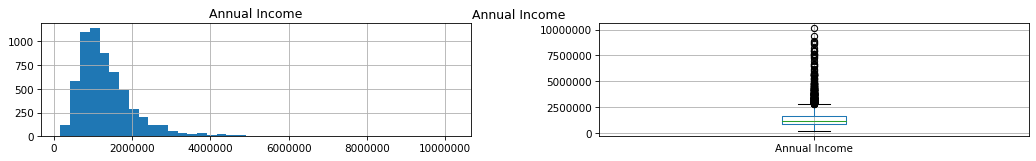

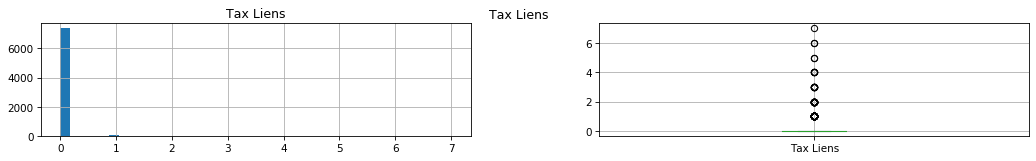

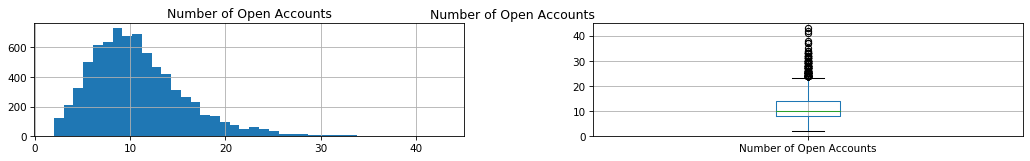

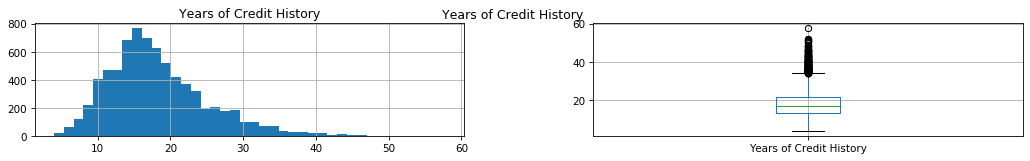

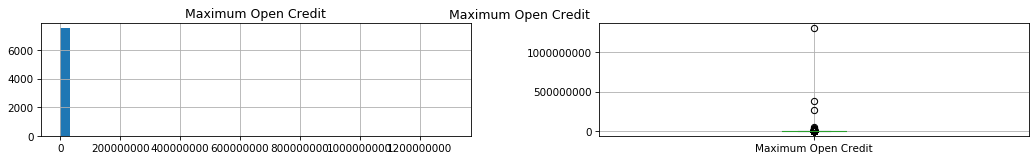

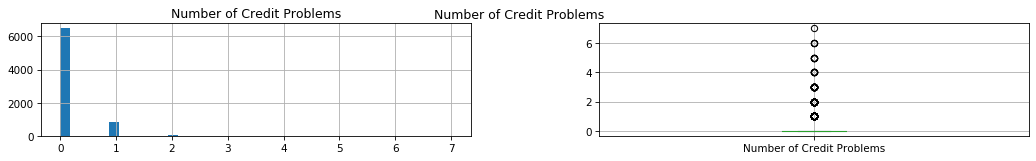

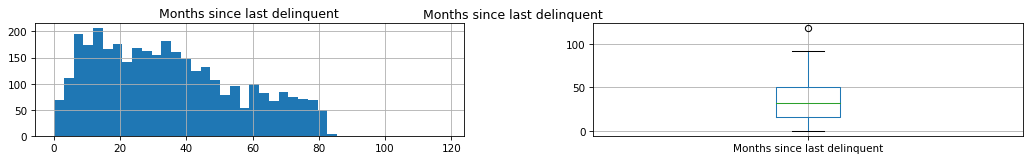

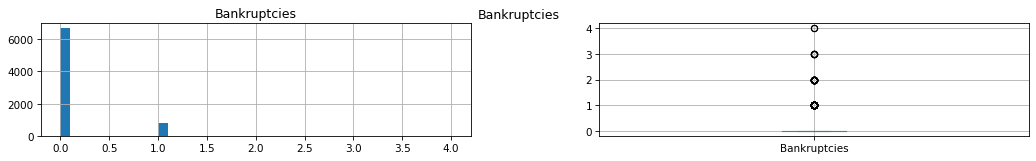

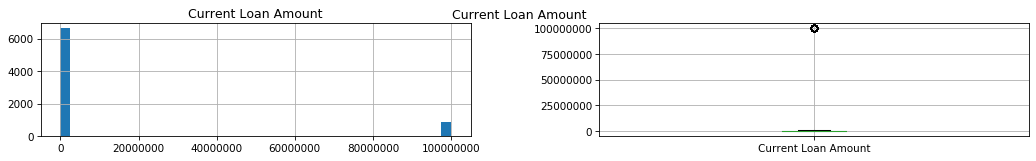

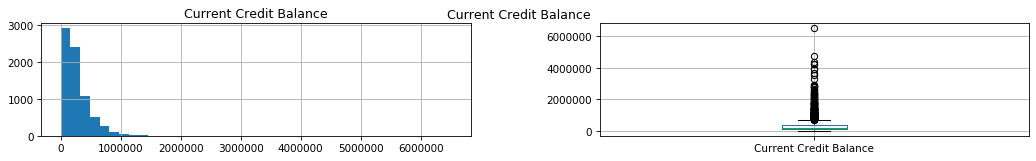

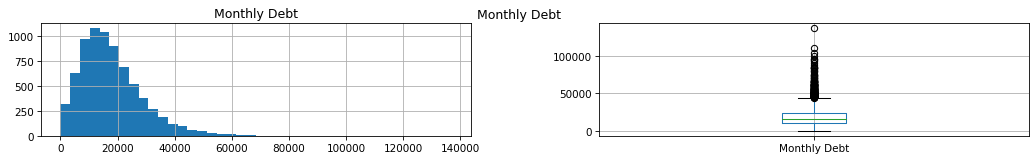

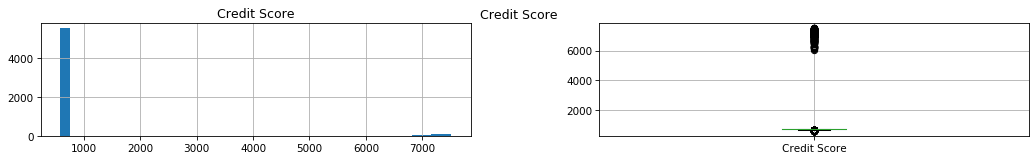

In [24]:
for col in reg_cols:
    draw_reg_col(df_train, col)

Выбросам подвержены следующие признаки:

Maximum Open Credit

Current Loan Amount

Credit Score

##### Maximum Open Credit

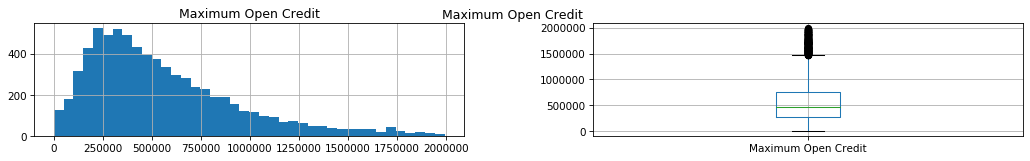

,Maximum Open Credit
Home Ownership: Rent,-0.186
Bankruptcies,-0.164
Number of Credit Problems,-0.147
Purpose: other,-0.060
Purpose: debt consolidation,0.077
Term (cast),0.118
Years in current job (cast),0.121
Home Ownership: Home Mortgage,0.181
Years of Credit History,0.248
Annual Income,0.321


In [25]:
moc_represent_df = df_train[df_train['Maximum Open Credit'] < 2000000]
draw_reg_col(moc_represent_df, 'Maximum Open Credit')

moc_represent_corr = moc_represent_df.corr().round(3)[['Maximum Open Credit']]
moc_important_corr = moc_represent_corr[0.05 < np.abs(moc_represent_corr['Maximum Open Credit'])]

moc_important_corr.sort_values('Maximum Open Credit')[:-1]

Как видно, Maximum Open Credit не оказывает существенного влияния на целевую переменную, а значит обработкой выбросов для этого признака можно пренебречь.

Тот же самый анализ был применён к Current Loan Amount и Credit Score. Но там был сделан вывод, что эти признаки лучше всего кореллируют с целевой переменной после масштабирования и бинаризации до 0 и 1:


##### Current Loan Amount

In [26]:
cla_avg = (df_train['Current Loan Amount'].max() + df_train['Current Loan Amount'].min()) / 2
cla_avg

50005620.5

In [27]:
def fix_cla(df):
    def process(value):
        if value < cla_avg:
            return 0
        elif value >= cla_avg:
            return 1
        else: 
            return value

    result = df.copy()
    result['Current Loan Amount (fix)'] = df['Current Loan Amount'].apply(process)    
    return result


pipeline.append(fix_cla)

In [28]:
df_train = fix_cla(df_train)
df_train[['Current Loan Amount', 'Current Loan Amount (fix)', 'Credit Default']].corr().round(2)

,Current Loan Amount,Current Loan Amount (fix),Credit Default
Current Loan Amount,1.00,1.00,-0.23
Current Loan Amount (fix),1.00,1.00,-0.23
Credit Default,-0.23,-0.23,1.00


##### Credit Score

In [29]:
cs_avg = (df_train['Credit Score'].max() + df_train['Credit Score'].min()) / 2
cs_avg

4047.5

In [30]:
def fix_cs(df):
    def process(value):
        if value < cs_avg:
            return 0
        elif value >= cs_avg:
            return 1
        else:
            return value

    result = df.copy()
    result['Credit Score (fix)'] = df['Credit Score'].apply(process)    
    return result


pipeline.append(fix_cs)

In [31]:
df_train = fix_cs(df_train)
df_train[['Credit Score', 'Credit Score (fix)', 'Credit Default']].corr().round(2)

,Credit Score,Credit Score (fix),Credit Default
Credit Score,1.00,1.00,0.44
Credit Score (fix),1.00,1.00,0.45
Credit Default,0.44,0.45,1.00


##### Обработка пропусков

In [32]:
len(df_train) - df_train.count()

Home Ownership                      0
Annual Income                    1557
Years in current job              371
Tax Liens                           0
Number of Open Accounts             0
Years of Credit History             0
Maximum Open Credit                 0
Number of Credit Problems           0
Months since last delinquent     4081
Bankruptcies                       14
Purpose                             0
Term                                0
Current Loan Amount                 0
Current Credit Balance              0
Monthly Debt                        0
Credit Score                     1557
Credit Default                      0
Years in current job (cast)         0
Term (cast)                         0
Home Ownership: Have Mortgage       0
Home Ownership: Home Mortgage       0
Home Ownership: Own Home            0
Home Ownership: Rent                0
Purpose: business loan              0
Purpose: buy a car                  0
Purpose: buy house                  0
Purpose: deb

##### Annual Income

In [33]:
def fill_ai(df):
    result = df.copy()
    median = df['Annual Income'].median()
    result['Annual Income (fill)'] = df['Annual Income'].fillna(median)    
    return result


pipeline.append(fill_ai)

In [34]:
df_train = fill_ai(df_train)
display(len(df_train) - df_train[['Annual Income', 'Annual Income (fill)']].count())
df_train[['Annual Income', 'Annual Income (fill)', 'Credit Default']].corr().round(2)

Annual Income           1557
Annual Income (fill)       0
dtype: int64

,Annual Income,Annual Income (fill),Credit Default
Annual Income,1.0,1.0,-0.1
Annual Income (fill),1.0,1.0,-0.1
Credit Default,-0.1,-0.1,1.0


##### Months since last delinquent

In [35]:
def fill_msld(df):
    result = df.copy()
    median = df['Months since last delinquent'].median()
    result['Months since last delinquent (fill)'] = df['Months since last delinquent'].fillna(median)
    return result


pipeline.append(fill_msld)

In [36]:
df_train = fill_msld(df_train)
display(len(df_train) - df_train[['Months since last delinquent', 'Months since last delinquent (fill)']].count())
df_train[['Months since last delinquent', 'Months since last delinquent (fill)', 'Credit Default']].corr().round(2)

Months since last delinquent           4081
Months since last delinquent (fill)       0
dtype: int64

,Months since last delinquent,Months since last delinquent (fill),Credit Default
Months since last delinquent,1.0,1.0,0.0
Months since last delinquent (fill),1.0,1.0,0.0
Credit Default,0.0,0.0,1.0


##### Credit Score (fix)

In [37]:
moc_represent_df = df_train.drop(columns=['Credit Score', 'Current Loan Amount'])

moc_represent_corr = moc_represent_df.corr().round(3)[['Credit Score (fix)']]
moc_important_corr = moc_represent_corr[0.03 < np.abs(moc_represent_corr['Credit Score (fix)'])]

moc_important_corr.sort_values('Credit Score (fix)')[moc_important_corr['Credit Score (fix)'] < 0.4]

,Credit Score (fix)
Current Loan Amount (fix),-0.111
Annual Income,-0.038
Annual Income (fill),-0.038
Term (cast),0.059


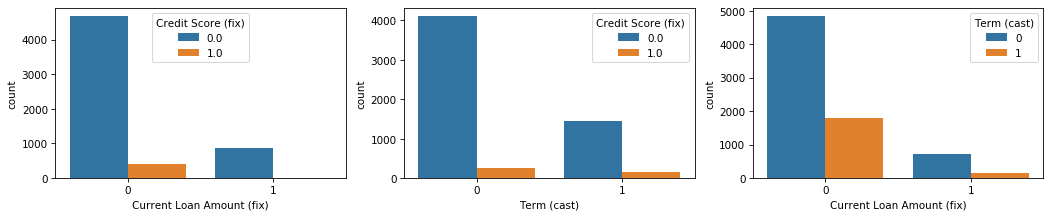

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 3), dpi=75)

sns.countplot(x='Current Loan Amount (fix)', hue='Credit Score (fix)', data=df_train, ax=ax1)
sns.countplot(x='Term (cast)', hue='Credit Score (fix)', data=df_train, ax=ax2)
sns.countplot(x='Current Loan Amount (fix)', hue='Term (cast)', data=df_train, ax=ax3)

plt.show()

In [39]:
def fill_cs(df):
    def process(value, cor):
        if value == 0 or value == 1:
            return value
        elif cor == 0:
            return 0
        else:
            return 0.5

    result = df.copy()
    result['Credit Score (fix_fill)'] = df['Credit Score (fix)'].combine(df['Current Loan Amount (fix)'] + df['Term (cast)'], 
                                                                         func=process)
    return result


pipeline.append(fill_cs)

In [40]:
df_train = fill_cs(df_train)
display(len(df_train) - df_train[['Credit Score (fix)', 'Credit Score (fix_fill)']].count())
df_train[['Credit Score (fix)', 'Credit Score (fix_fill)', 'Credit Default']].corr().round(2)

Credit Score (fix)         1557
Credit Score (fix_fill)       0
dtype: int64

,Credit Score (fix),Credit Score (fix_fill),Credit Default
Credit Score (fix),1.00,1.00,0.45
Credit Score (fix_fill),1.00,1.00,0.41
Credit Default,0.45,0.41,1.00


##### Bankruptcies

In [41]:
df_train['Bankruptcies'].unique()

array([ 1.,  0.,  3., nan,  2.,  4.])

In [42]:
def fill_bankruptcies(df):
    result = df.copy()
    result['Bankruptcies (fill)'] = df['Bankruptcies'].fillna(0)
    return result


pipeline.append(fill_bankruptcies)

In [43]:
df_train = fill_bankruptcies(df_train)
df_train['Bankruptcies (fill)'].unique()

array([1., 0., 3., 2., 4.])

### Анализ данных

##### Анализ целевой переменной¶
##### Обзор распределения

In [44]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

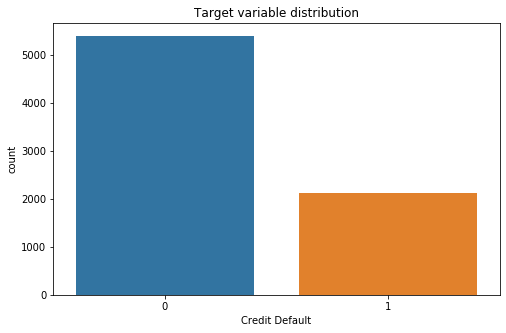

In [45]:
plt.figure(figsize=(8, 5))

sns.countplot(x='Credit Default', data=df_train)

plt.title('Target variable distribution')
plt.show()

##### Корреляция с базовыми признаками

In [46]:
target_col = 'Credit Default'
feature_cols = [
    'Annual Income (fill)',
    'Years in current job (cast)',
    'Tax Liens',
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
    'Number of Credit Problems',
    'Months since last delinquent (fill)',
    'Bankruptcies (fill)',
    'Term (cast)',
    'Current Loan Amount (fix)',
    'Current Credit Balance',
    'Monthly Debt',
    'Credit Score (fix_fill)',
    'Home Ownership: Have Mortgage',
    'Home Ownership: Home Mortgage',
    'Home Ownership: Own Home',
    'Home Ownership: Rent',
    'Purpose: business loan',
    'Purpose: buy a car',
    'Purpose: buy house',
    'Purpose: debt consolidation',
    'Purpose: educational expenses',
    'Purpose: home improvements',
    'Purpose: major purchase',
    'Purpose: medical bills',
    'Purpose: moving',
    'Purpose: other',
    'Purpose: renewable energy',
    'Purpose: small business',
    'Purpose: take a trip',
    'Purpose: vacation',
    'Purpose: wedding',
]

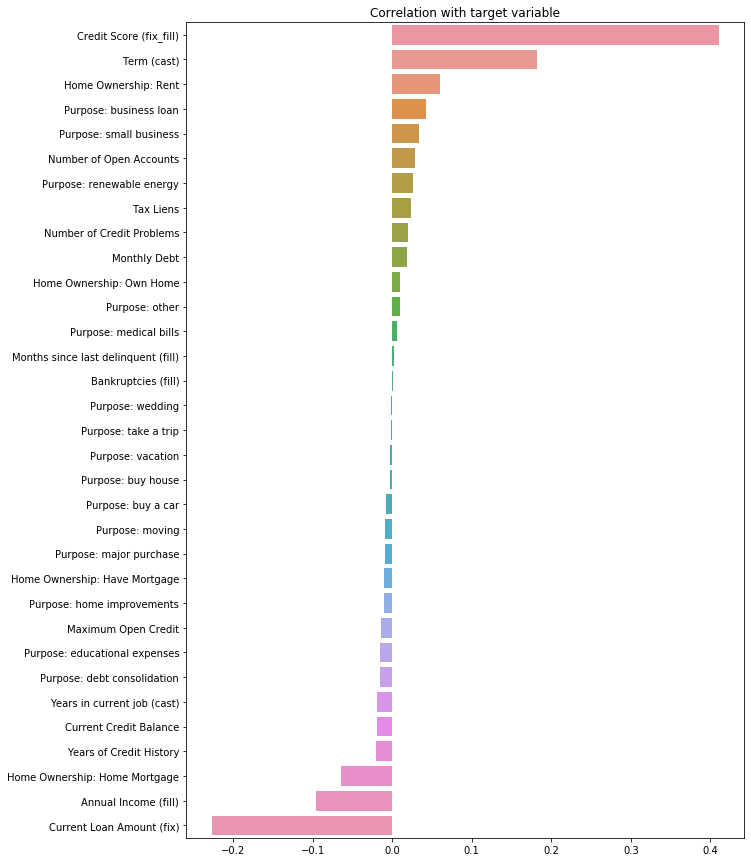

In [47]:
corr_with_target = df_train[feature_cols + [target_col]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 15))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

##### Анализ признакового пространства

##### Матрица корреляций

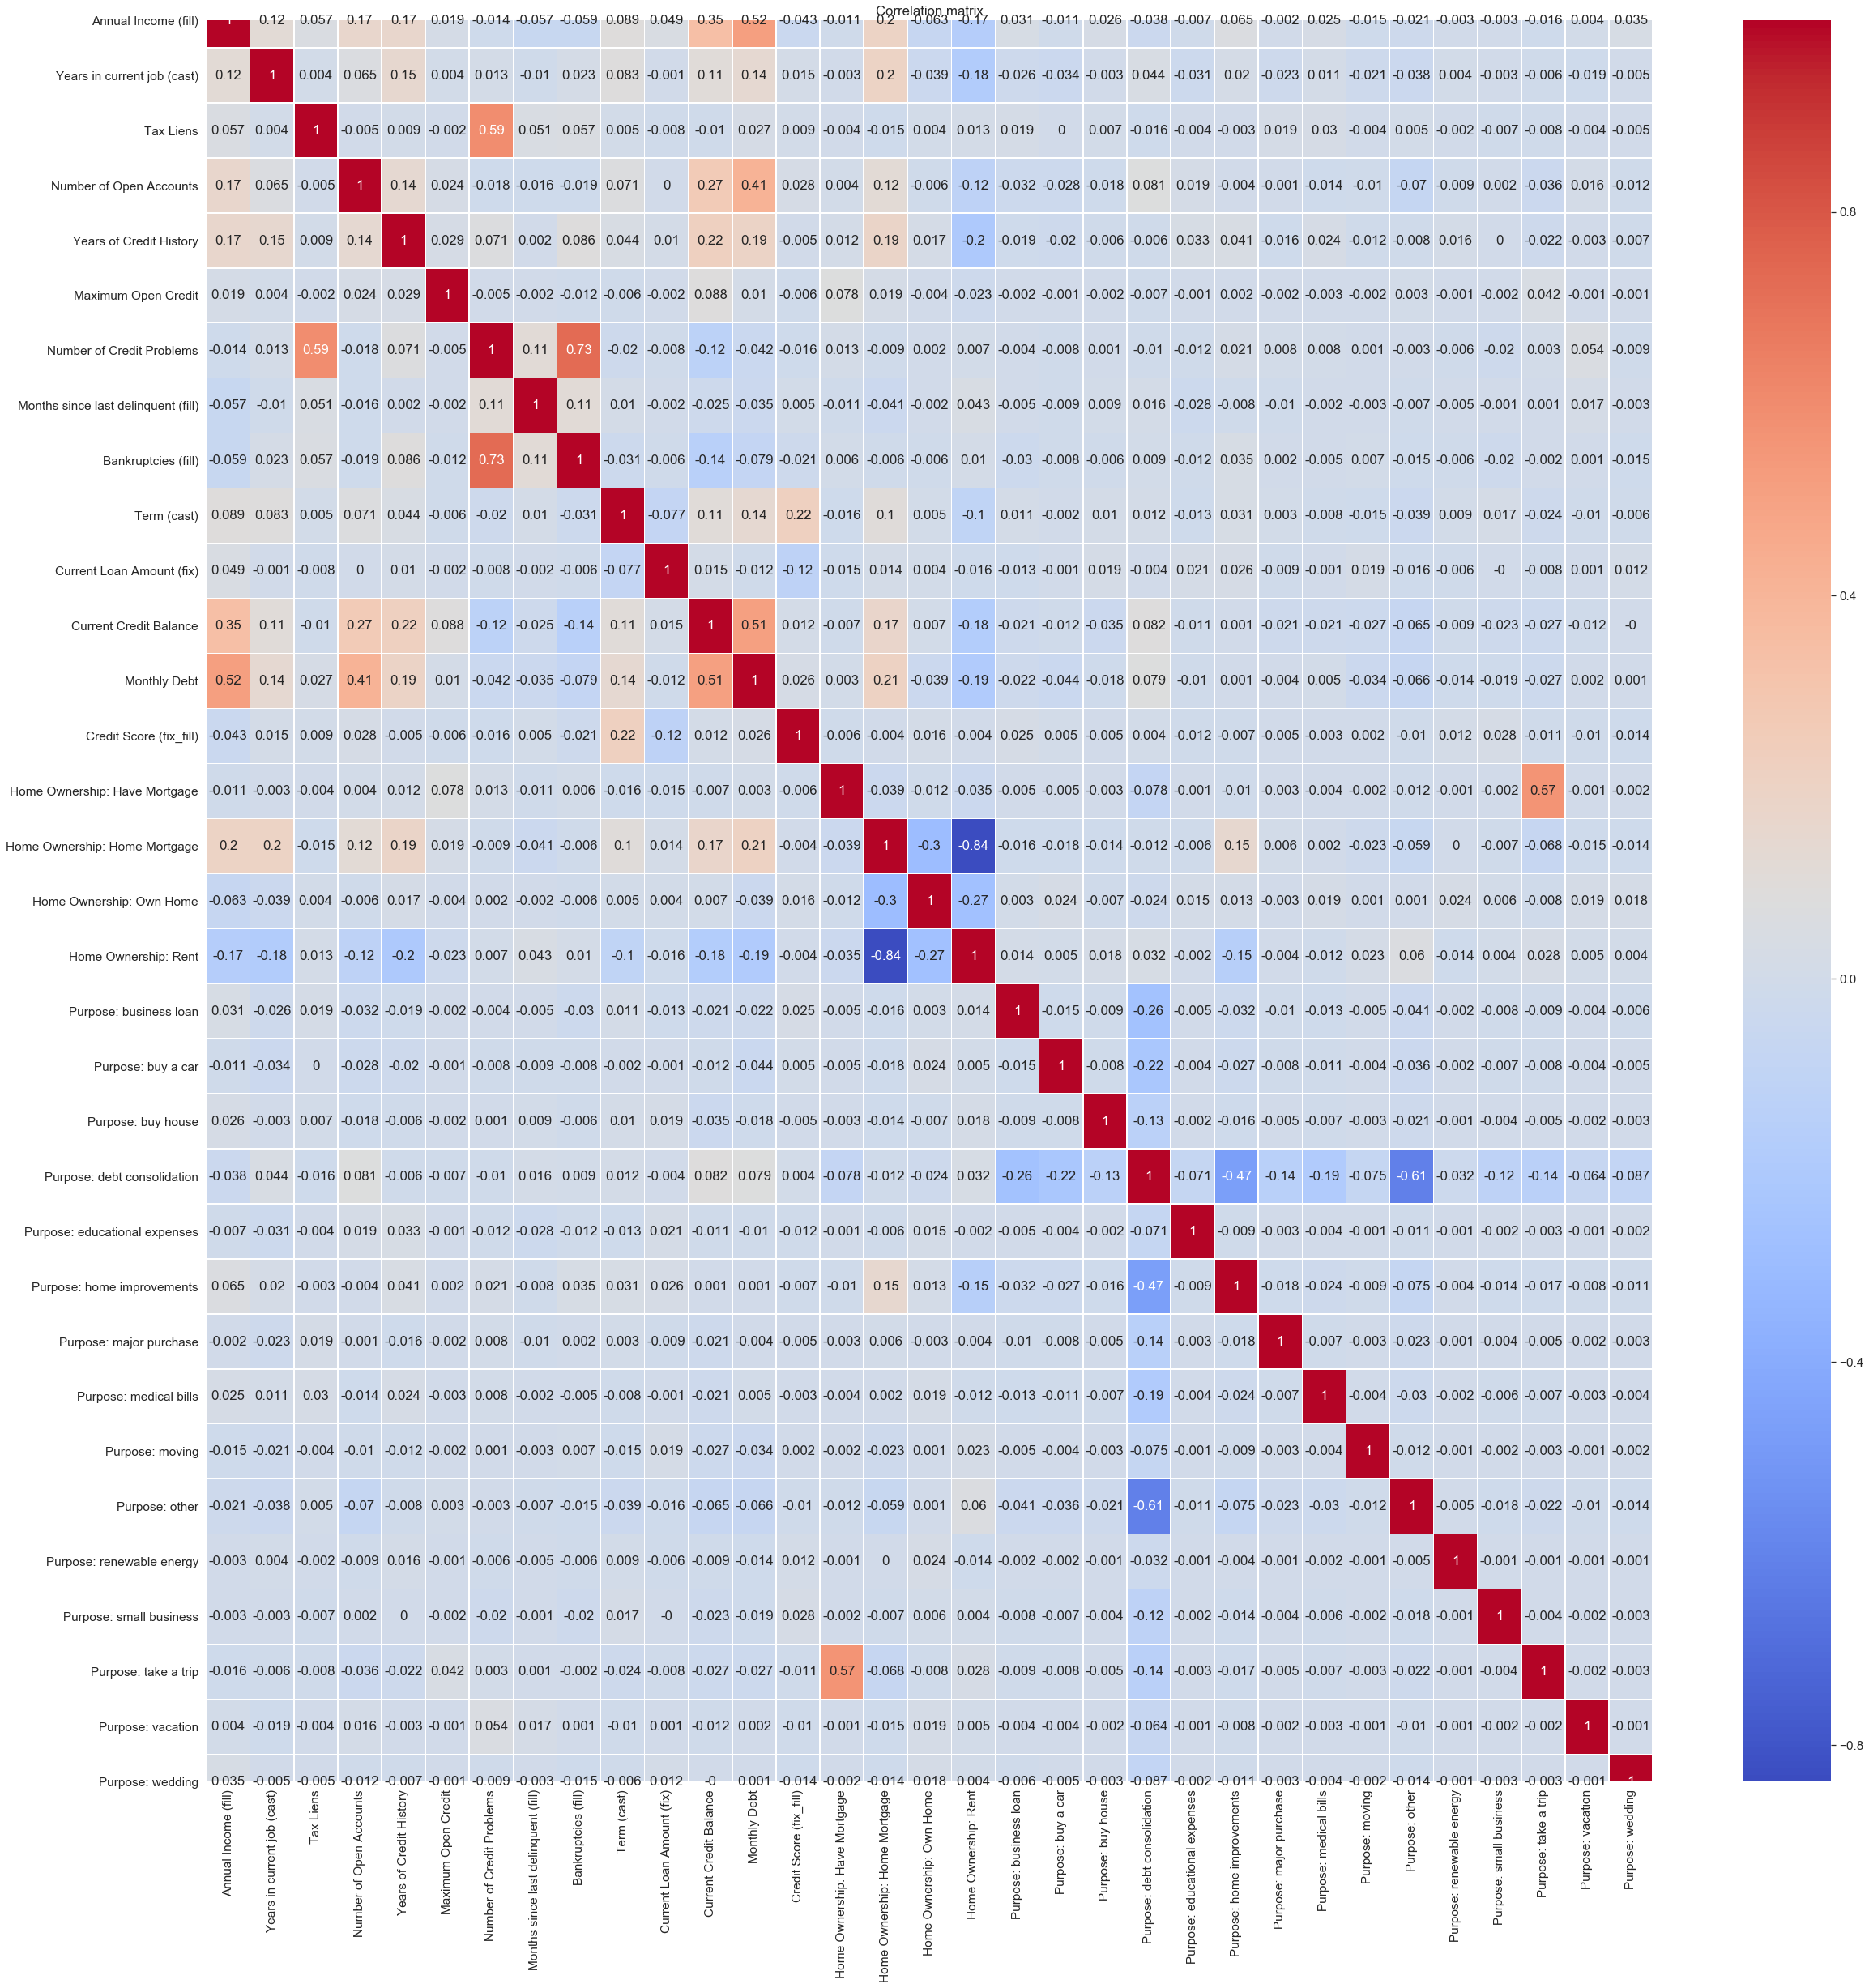

In [48]:
plt.figure(figsize = (40,40))

sns.set(font_scale=1.4)
sns.heatmap(df_train[feature_cols].corr().round(3), annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### Отбор признаков

##### Нормализация

In [49]:
scaler = StandardScaler()
scaler.fit(df_train[feature_cols])


def prep_scale(df):
    result = df.copy()
    result[feature_cols] = scaler.transform(df[feature_cols])
    return result


pipeline.append(prep_scale)

In [50]:
df_scaled = prep_scale(df_train)

##### Разбиение на train и test

In [51]:
X = df_scaled[feature_cols]
y = df_scaled[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)

##### Балансировка классов

In [52]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [53]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_col)

df_balanced[target_col].value_counts()

0    4074
1    3102
Name: Credit Default, dtype: int64

In [54]:
X_train = df_balanced.drop(columns=target_col)
y_train = df_balanced[target_col]

### Подбор моделей, получение бейзлана

In [55]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

##### Логистическая регрессия

In [56]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.89      0.77      4074
           1       0.76      0.45      0.56      3102

    accuracy                           0.70      7176
   macro avg       0.72      0.67      0.67      7176
weighted avg       0.71      0.70      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1313
           1       0.63      0.44      0.52       562

    accuracy                           0.76      1875
   macro avg       0.71      0.67      0.68      1875
weighted avg       0.74      0.76      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1170  143
1                314  248


##### k-ближайших соседей

In [57]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      4074
           1       0.79      0.70      0.74      3102

    accuracy                           0.79      7176
   macro avg       0.79      0.78      0.78      7176
weighted avg       0.79      0.79      0.79      7176

TEST

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1313
           1       0.47      0.50      0.48       562

    accuracy                           0.68      1875
   macro avg       0.62      0.63      0.63      1875
weighted avg       0.69      0.68      0.68      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               998  315
1               283  279


##### CatBoost

In [58]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=42)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4074
           1       0.92      0.81      0.86      3102

    accuracy                           0.89      7176
   macro avg       0.89      0.88      0.88      7176
weighted avg       0.89      0.89      0.89      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.85      0.81      1313
           1       0.56      0.46      0.51       562

    accuracy                           0.73      1875
   macro avg       0.67      0.65      0.66      1875
weighted avg       0.72      0.73      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1111  202
1                303  259


### Выбор наилучшей модели, настройка гиперпараметров

In [59]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

##### Подбор гиперпараметров

In [70]:
params = {'n_estimators':[100, 250, 500], 
          'max_depth':[2, 6, 12],
          'learning_rate':[0.01, 0.05, 0.1]}

In [71]:
cv = KFold(n_splits=3, random_state=21, shuffle=True)

In [72]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

Wall time: 6min 7s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001BCCAD2B208>,
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [2, 6, 12],
                                        'n_estimators': [100, 250, 500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [73]:
rs.best_params_

{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.05}

In [74]:
rs.best_score_

0.8147762567910538

##### Выбор наилучшей модели

In [75]:
%%time

final_model = catb.CatBoostClassifier(
    n_estimators=500,
    max_depth=12,
    learning_rate=0.05,
    silent=True, 
    random_state=42,
)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4074
           1       1.00      1.00      1.00      3102

    accuracy                           1.00      7176
   macro avg       1.00      1.00      1.00      7176
weighted avg       1.00      1.00      1.00      7176

TEST

              precision    recall  f1-score   support

           0       0.78      0.90      0.83      1313
           1       0.63      0.39      0.48       562

    accuracy                           0.75      1875
   macro avg       0.70      0.65      0.66      1875
weighted avg       0.73      0.75      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1185  128
1                342  220
Wall time: 47.6 s


### Проверка качества, борьба с переобучением

##### Снижение степени переобучения

In [76]:
final_model = catb.CatBoostClassifier(
    n_estimators=500, 
    max_depth=12,
    learning_rate=0.05,
    l2_leaf_reg=5,
    silent=True, 
    random_state=42,
)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4074
           1       1.00      1.00      1.00      3102

    accuracy                           1.00      7176
   macro avg       1.00      1.00      1.00      7176
weighted avg       1.00      1.00      1.00      7176

TEST

              precision    recall  f1-score   support

           0       0.77      0.90      0.83      1313
           1       0.62      0.39      0.48       562

    accuracy                           0.75      1875
   macro avg       0.70      0.64      0.66      1875
weighted avg       0.73      0.75      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1180  133
1                343  219


##### Подбор оптимального размера выборки, кривая обучения

In [77]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, 
        cv=cv, 
        scoring='f1',
        train_sizes=train_sizes, 
        n_jobs=n_jobs,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [78]:
final_model = catb.CatBoostClassifier(
    n_estimators=500, 
    max_depth=12,
    learning_rate=0.05,
    l2_leaf_reg=5,
    class_weights=[1, 2.5],
    silent=True, 
    random_state=42,
)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4074
           1       1.00      1.00      1.00      3102

    accuracy                           1.00      7176
   macro avg       1.00      1.00      1.00      7176
weighted avg       1.00      1.00      1.00      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1313
           1       0.52      0.53      0.52       562

    accuracy                           0.71      1875
   macro avg       0.66      0.66      0.66      1875
weighted avg       0.71      0.71      0.71      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1040  273
1                266  296


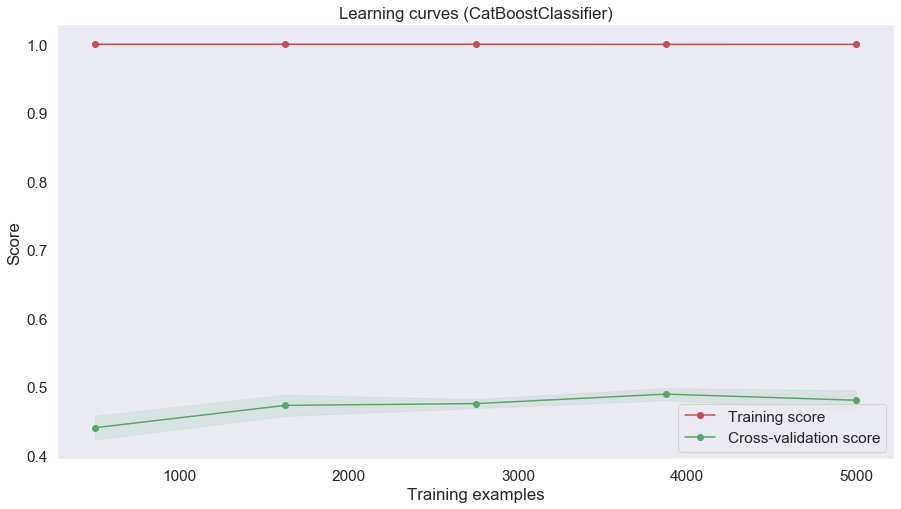

In [79]:
show_learning_curve_plot(final_model, X, y)

##### Выбор порога вероятности для определения класса

In [80]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

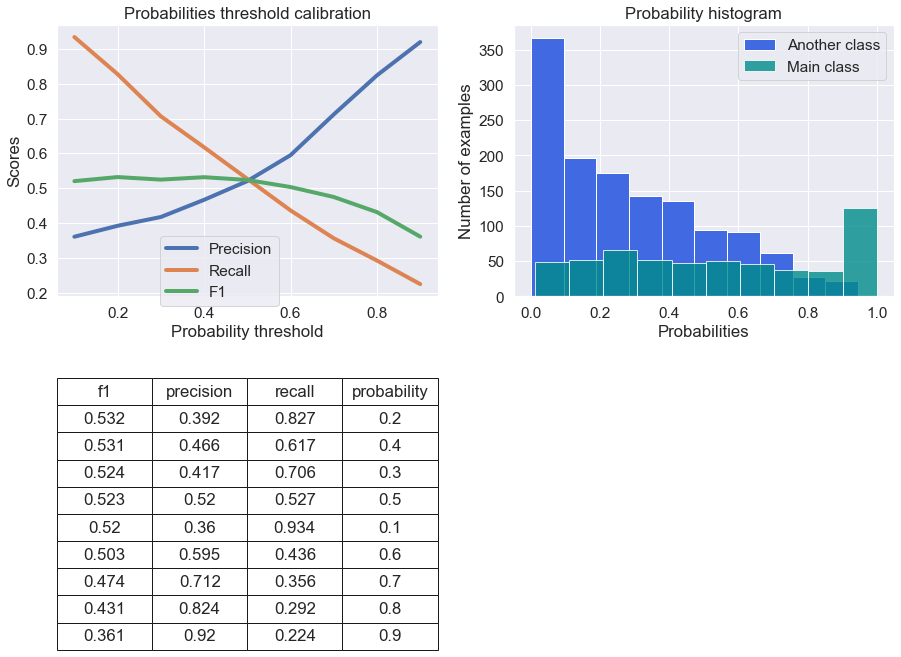

In [81]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

##### Важность признаков

In [82]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

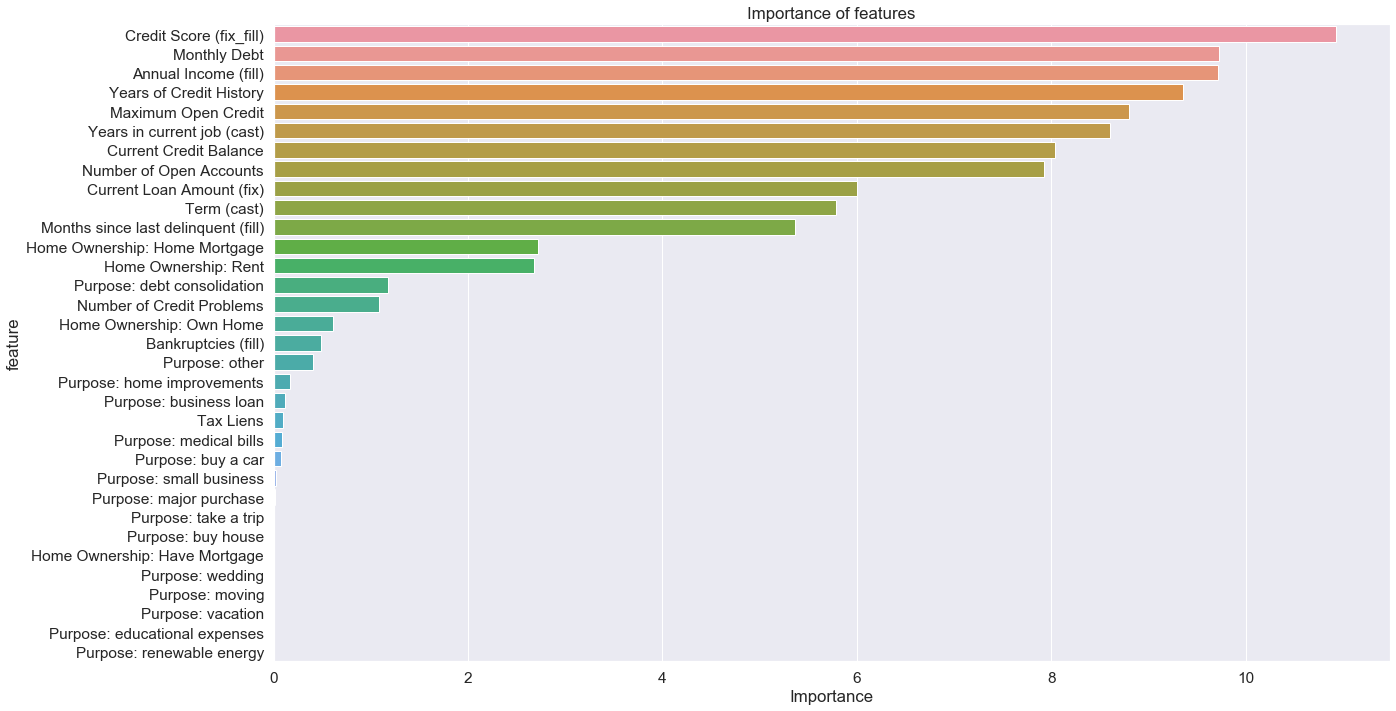

In [83]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

##### Финальная модель

In [84]:
final_model = catb.CatBoostClassifier(
    n_estimators=500, 
    max_depth=12,
    learning_rate=0.05,
    l2_leaf_reg=5,
    class_weights=[1, 2.5],
    silent=True, 
    random_state=42,
)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4074
           1       1.00      1.00      1.00      3102

    accuracy                           1.00      7176
   macro avg       1.00      1.00      1.00      7176
weighted avg       1.00      1.00      1.00      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1313
           1       0.52      0.53      0.52       562

    accuracy                           0.71      1875
   macro avg       0.66      0.66      0.66      1875
weighted avg       0.71      0.71      0.71      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1040  273
1                266  296


In [85]:
def predict_df(df): 
    return final_model.predict(df[feature_cols])

pipeline.append(predict_df)

### Интерпретация результатов

##### Наиболее важными параметрами оказались кредитный скоринг, величина ежемесячного долга и годовой доход

### Экспорт результатов

In [86]:
def run_pipeline(df):
    result = df.copy()
    for step in pipeline:
        result = step(result)
    return result

In [87]:
df_test_predicted = pd.DataFrame(run_pipeline(df_test), columns=[target_col])
df_test_predicted.head(3)

,Credit Default
0,1
1,0
2,1


In [88]:
df_test_predicted.to_csv(r'SVolkov_predictions.csv', index=False)